In [9]:
import fiona
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from time import time
from tqdm import tqdm
import xarray as xr
import torch
import torch.nn as nn
import matplotlib.colors as colors
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

seed = 1234
np.random.seed(seed)

## 1. Read Xarray Files


In [10]:
def get_filenames(directory):
    filenames = sorted(os.listdir(directory))
    return [f for f in filenames if f.endswith(".nc")]


def get_path(directory, filename):
    return os.path.join(directory, filename)


def get_basename(path):
    return os.path.basename(path)


def get_month_year(file_name, dtype="ppt"):
    """Get month and year from file name"""
    if dtype == "ppt":
        time = pd.Timestamp("-".join(file_name.split(".")[0].split("_")[1:]))
        month, year = time.month, time.year
    elif dtype == "sst":
        year, month = file_name.split(".")[-2][-6:-2], file_name.split(".")[-2][-2:]
        month, year = int(month), int(year)
    else:
        print(f"dtype {dtype} not implemented. Use ppt or sst.")
        month, year = None, None
    return month, year


def read_xr(path, dtype="ppt"):
    """Read xarray file"""
    file_data = xr.load_dataset(path, engine="netcdf4")
    file_name = get_basename(path)
    month, year = get_month_year(file_name, dtype)
    xr_data = [file_name, year, month]

    if dtype == "ppt":
        file_data = file_data.rename_vars(
            {list(file_data.keys())[1]: "ppt", "longitude": "lon", "latitude": "lat"}
        )

        # Coarsen data to reduce resolution
        file_data = file_data.coarsen(latitude=4, longitude=4, boundary="trim").mean()
        #         file_data = file_data.sel(longitude=slice(-300, -100))

        ##Slice for west coast
        file_data = file_data.sel(longitude=slice(0, 150))

        xr_data.append(file_data.ppt.values)
        columns = list("FYMD")
        columns[-1] = "ppt"

    elif dtype == "sst":
        # Coarsen data to reduce resolution
        #         file_data = file_data.coarsen(lat = 4, lon = 4, boundary = "trim").mean()

        ##Slice for west coast
        #         file_data = file_data.sel(lon=slice(100, 400))

        xr_data.extend([file_data.sst.values, file_data.ssta.values])
        columns = list("FYMDA")
        columns[-2], columns[-1] = "sst", "ssta"

    else:
        print(f"dtype {dtype} not implemented. Use ppt or sst.")

    longitude, latitude = file_data.lon.values, file_data.lat.values
    return xr_data, longitude, latitude, columns


def load_data(directory, dtype="ppt"):
    """Load directory files in a pandas dataframe"""
    filenames = get_filenames(directory)
    data_info_list = []
    for i, file_name in tqdm(enumerate(filenames)):
        path = get_path(directory, file_name)
        xr_data, longitude, latitude, columns = read_xr(path, dtype)
        data_info_list.append(xr_data)
    df = pd.DataFrame([p for p in data_info_list], columns=columns)
    return df, latitude, longitude

#### `Change ppt_directory and sst_directory based on your directories`


In [11]:
ppt_directory = "data/ppt-nc-1895-2020"
sst_directory = "data/ERSST"

In [12]:
### Load ppt data
ppt_df, lat, lon = load_data(ppt_directory, dtype="ppt")

759it [00:10, 69.07it/s]


### PPT Levels in different U.S. States


In [13]:
def show_states(west_coast=True, state_file="States/cb_2018_us_state_20m.shp"):
    shape = fiona.open(state_file)
    for s in shape:
        pts = s["geometry"]["coordinates"]
        for p in pts:
            state = np.array(p).squeeze()
            if state[:, 1].min() < 50 and state[:, 1].min() > 22:
                if not west_coast:
                    plt.plot(state[:, 0], state[:, 1], color="black")
                elif np.max(state[:, 0]) < -100:  # plot only west coast
                    plt.plot(state[:, 0], state[:, 1], color="black")

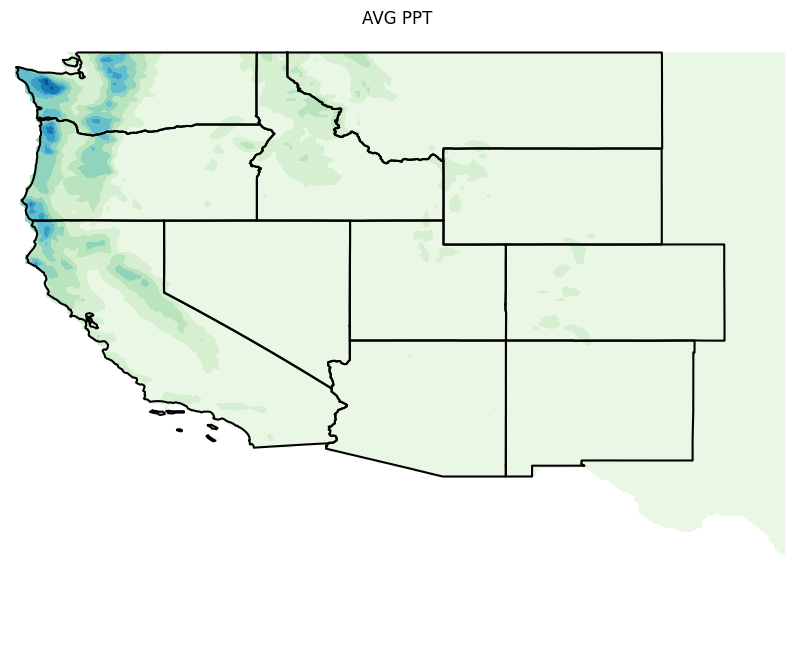

In [14]:
avg_ppt = ppt_df["ppt"].mean()

plt.figure(figsize=(10, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, avg_ppt, cmap="GnBu")
show_states()
plt.axis("off")
plt.title("AVG PPT")
plt.show()
plt.close()

In [15]:
### Load sst data
sst_df, _, _ = load_data(sst_directory, dtype="sst")
sst_df

1644it [00:15, 102.84it/s]


,F,Y,M,sst,ssta
0,ersst.v5.188001.nc,1880,1,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1,ersst.v5.188002.nc,1880,2,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
2,ersst.v5.188003.nc,1880,3,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
3,ersst.v5.188004.nc,1880,4,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
4,ersst.v5.188005.nc,1880,5,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
...,...,...,...,...,...
1639,ersst.v5.201608.nc,2016,8,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1640,ersst.v5.201609.nc,2016,9,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1641,ersst.v5.201610.nc,2016,10,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1642,ersst.v5.201611.nc,2016,11,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...


### SST Levels


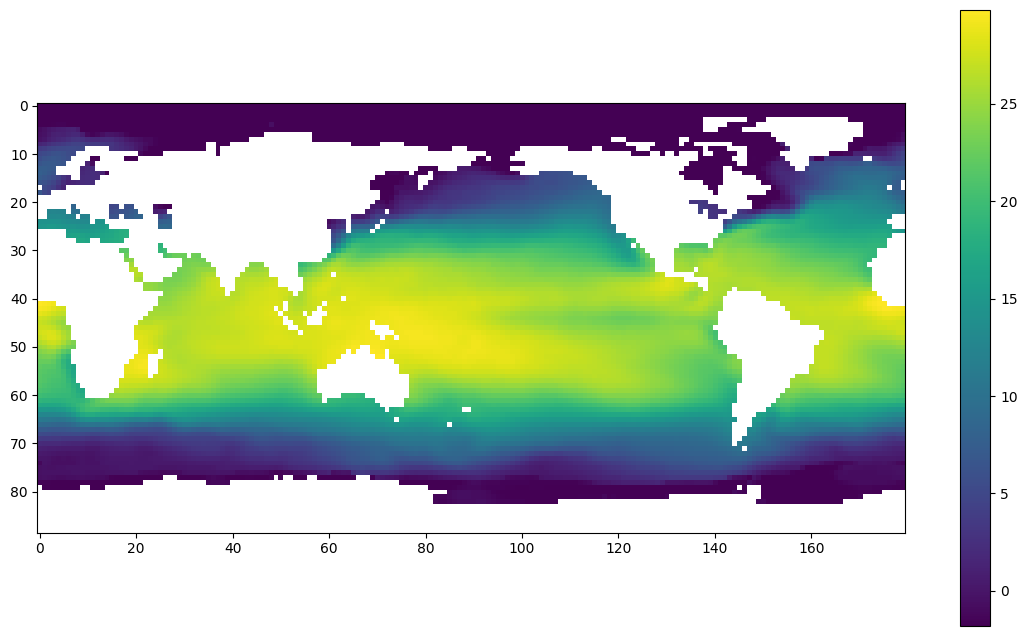

(1644,)

In [16]:
plt.figure(figsize=(14, 8))
sst_example = sst_df["sst"].iloc[0]
plt.imshow(np.flipud(sst_example.reshape(sst_example.shape[-2], sst_example.shape[-1])))
plt.colorbar()
plt.show()
sst_df["sst"].shape

In [17]:
## Check shapes of ppt and sst
sst_df["sst"].iloc[0].shape, ppt_df["ppt"].iloc[0].shape

((1, 1, 89, 180), (155, 150))

In [18]:
# get rainfall month and year
rain_row = ppt_df.iloc[0]
m, y = rain_row["M"], rain_row["Y"]

# get sst month and year
sst_row = sst_df[(sst_df["M"] == m) & (sst_df["Y"] == y)]  # bitmask filters for month and year
index_position = sst_row.index[0]  # index returns Index object, so we need to get the first element

# if index_position < 24:
#     # do something, though this should never happen cuz sst starts far earlier

prev24 = sst_df.iloc[index_position - 24 : index_position]

In [19]:
import pandas as pd

# Sample DataFrame
data = {
    "month": [1, 5, 7, 5, 12],
    "year": [2020, 2021, 2021, 2022, 2020],
    "data": ["A", "B", "C", "D", "E"],  # Additional data column for illustration
}
df = pd.DataFrame(data)

# Your target month and year
target_month = 5
target_year = 2021

# Create a boolean mask to filter the DataFrame
mask = (df["month"] == target_month) & (df["year"] == target_year)

# Apply the mask to the DataFrame
filtered_df = df[mask]

# Display the filtered DataFrame
print(filtered_df)

   month  year data
1      5  2021    B


## 2. Combine SST and PPT


In [20]:
df = sst_df.merge(ppt_df, on=["Y", "M"], suffixes=("_sst", "_ppt"), how="inner")

## 3. Add Temporal Features


In [21]:
def add_time(df):
    """Add Time Column"""
    min_year = np.min(df["Y"])
    df["T"] = (df["Y"] - min_year) * 12 + df["M"]
    return df


def add_season(df):
    """adds Season Column (0 for months 1,2,3 and 1 for months 10,11,12)"""
    df["season"] = ((df["M"] - 1) // 4).astype(bool).astype(int)
    return df


df = add_season(add_time(df))
df.to_csv("data/df.csv", index=False)

### ppt has data for only months 1,2,3,10,11,12. While sst has all months.


## 4. Add Clusters


In [22]:
clusters = np.load("clusters.npy")

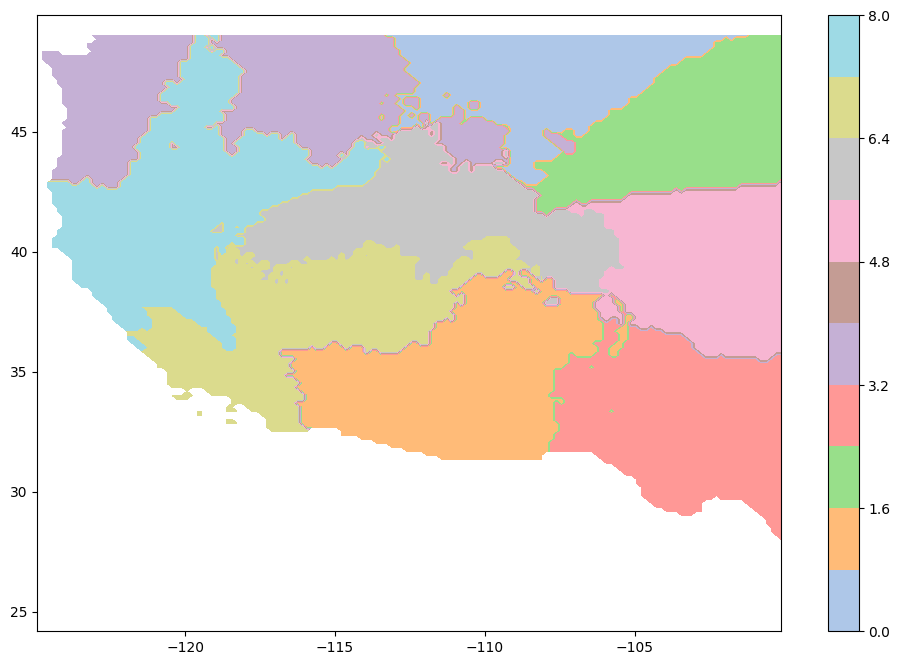

np.unique(clusters):  [ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan]


In [23]:
plt.figure(figsize=(12, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, clusters, levels=10, cmap="tab20")
plt.colorbar()
plt.show()
print("np.unique(clusters): ", np.unique(clusters))

In [24]:
def average_clusters(image, cluster_array, return_image=True):
    """Average the values of each cluster in the image"""
    unique_clusters = np.unique(cluster_array)  # Find unique cluster labels

    if return_image:
        # Initialize an array to store the average values
        averaged_image = np.zeros_like(image, dtype=float)
    else:
        cluster_averages = []

    for cluster_label in unique_clusters:
        # Mask the original image with the current cluster label
        masked_image = np.where(cluster_array == cluster_label, image, 0)

        # Calculate the average value for the current cluster
        cluster_size = np.sum(cluster_array == cluster_label)
        cluster_average = np.sum(masked_image) / cluster_size

        if return_image:
            # Replace pixels in the averaged image with the cluster average
            averaged_image += np.where(
                cluster_array == cluster_label, cluster_average, 0
            )
        else:
            cluster_averages.append(cluster_average)

    return averaged_image if return_image else np.array(cluster_averages)


avg_clusters = average_clusters(df.iloc[0].ppt, clusters)
avg_clusters

/var/folders/j3/ll6yjvb96yjb1gn7mk4x45zh0000gn/T/ipykernel_40474/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

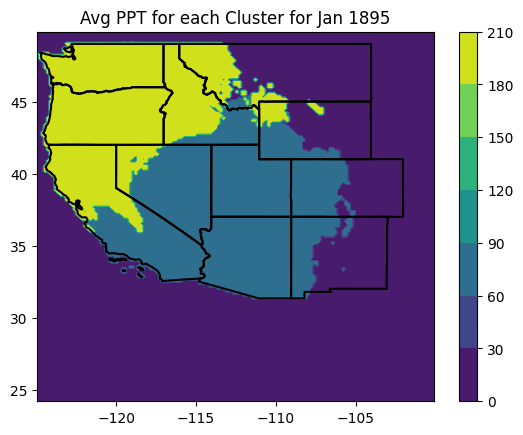

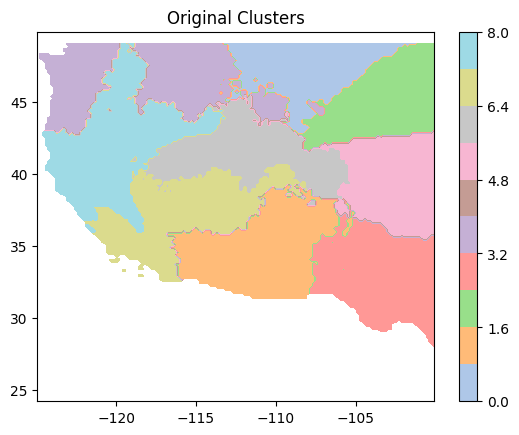

In [25]:
plt.contourf(xx, yy, avg_clusters)
plt.colorbar()
show_states()
plt.title("Avg PPT for each Cluster for Jan 1895")
plt.show()

xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, clusters, levels=10, cmap="tab20")
plt.colorbar()
plt.title("Original Clusters")
plt.show()

In [26]:
df["ppt_cluster"] = df["ppt"].apply(lambda x: average_clusters(x, clusters))
df["ppt_cluster_vector"] = df["ppt"].apply(
    lambda x: average_clusters(x, clusters, return_image=False)[:-1]
)

/var/folders/j3/ll6yjvb96yjb1gn7mk4x45zh0000gn/T/ipykernel_40474/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size
/var/folders/j3/ll6yjvb96yjb1gn7mk4x45zh0000gn/T/ipykernel_40474/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size


## 5. Add Quantiles


In [27]:
def get_quantiles(df, cluster=True):

    vector = df.ppt_cluster_vector if cluster else df.ppt

    ppt_vector = np.stack(vector.apply(lambda x: x.reshape(-1))).T
    q1 = np.quantile(ppt_vector, 0.25, axis=1, keepdims=True).flatten()
    q2 = np.quantile(ppt_vector, 0.5, axis=1, keepdims=True).flatten()
    q3 = np.quantile(ppt_vector, 0.75, axis=1, keepdims=True).flatten()
    return q1, q2, q3


q1, q2, q3 = get_quantiles(df)
q1

array([ 9.5338221 , 12.17312131,  9.24412442,  7.47316639, 94.40965887,
        8.27551748, 25.58297759, 13.8765325 , 42.52929087])

In [28]:
def get_quantized(x, q1, q2, q3):
    output = np.zeros_like(x)
    output[x <= q1] = 1
    q2_arr = np.array(x > q1) * np.array(x <= q2)
    q3_arr = np.array(x > q2) * np.array(x <= q3)
    output[q2_arr] = 2
    output[q3_arr] = 3
    output[x > q3] = 4
    return output

In [29]:
df["ppt_cluster_vector_quantized"] = df["ppt_cluster_vector"].apply(
    lambda x: get_quantized(x, q1, q2, q3)
)
df[["T", "M", "ppt_cluster_vector_quantized"]]

,T,M,ppt_cluster_vector_quantized
0,1,1,"[4.0, 4.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0]"
1,2,2,"[3.0, 3.0, 3.0, 4.0, 1.0, 4.0, 2.0, 3.0, 2.0]"
2,3,3,"[2.0, 1.0, 3.0, 1.0, 1.0, 2.0, 3.0, 3.0, 2.0]"
3,10,10,"[1.0, 3.0, 1.0, 4.0, 1.0, 3.0, 1.0, 1.0, 1.0]"
4,11,11,"[4.0, 4.0, 4.0, 4.0, 2.0, 3.0, 3.0, 2.0, 1.0]"
...,...,...,...
727,1454,2,"[1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 1.0, 2.0, 1.0]"
728,1455,3,"[3.0, 1.0, 4.0, 2.0, 4.0, 4.0, 4.0, 3.0, 4.0]"
729,1462,10,"[4.0, 1.0, 4.0, 2.0, 4.0, 2.0, 4.0, 2.0, 4.0]"
730,1463,11,"[2.0, 3.0, 3.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0]"


## Organizing Data into y_labels and x_input

Want to create a dataframe of sea surface temperature input for each cluster precipitation estimation (1, 2, 3, or 4).
The input data should be 24 months worth of sea surface temperature data. This data is stored in a quadruple vector.
For each a ppt_cluster_vector quantity, grab the last 24 months of "sst" quadruple vector data information.
to test.


### Organizing Y Labels and processing ppt clusters


In [30]:
y_labels = df.loc[:,["Y", "M", "ppt_cluster_vector_quantized"]]
y_labels = y_labels.rename(columns={"M": "month", "Y": "year"})
y_labels["date"] = pd.to_datetime(y_labels[["month","year"]].assign(day=1))
y_labels["date"] = y_labels['date']

y_labels.drop(["month"], axis=1, inplace=True)
y_labels.drop(["year"], axis=1, inplace=True)
y_labels.set_index("date", inplace=True)

ppt_data = np.array(y_labels["ppt_cluster_vector_quantized"]) - 1
# get all 9 clusters in a list, where each cluster is the ith column in ppt_data
clusters = [np.array([x[i] for x in ppt_data]) for i in range(len(ppt_data[0]))]
clusters = np.array(clusters)

In [31]:
sst_condensed = sst_df.loc[:,["Y", "M", "sst"]]
sst_condensed = sst_condensed.rename(columns={"M": "month", "Y": "year"})
sst_condensed["date"] = pd.to_datetime(sst_condensed[["month","year"]].assign(day=1))
sst_condensed["date"] = sst_condensed['date']

sst_condensed.drop(["month"], axis=1, inplace=True)
sst_condensed.drop(["year"], axis=1, inplace=True)
sst_condensed.set_index("date", inplace=True)

### Process sst data for forest tree classification on entire dataset


In [32]:
x_input_rows = []
for date in y_labels.index:
    start_date = date - pd.DateOffset(months=23)
    end_date = date
    sst_in_range = np.array(sst_condensed.loc[start_date:end_date, 'sst'].tolist()) # shape here is (24, 1, 1, 89, 180)
    IO_TP_sst_in_range = sst_in_range.flatten() #1 x 384480
    sst_in_range = sst_in_range[~np.isnan(sst_in_range)] # 263712
    
    x_input_rows.append({'start date': start_date, 'end date' : end_date, 'sst rows': sst_in_range})

x_input = pd.DataFrame(x_input_rows)
x_input["start date"] = x_input["start date"].dt.to_period('M')
x_input["end date"] = x_input["end date"].dt.to_period('M')
sst_data_all = np.array([xi.tolist() for xi in np.array(x_input[:]["sst rows"])])

### Check if y labels are distributed


In [33]:
# put all data from y_labels into a single, one-dimensional array
ppt_data_all = np.array(y_labels["ppt_cluster_vector_quantized"]) - 1
ppt_data_all = np.array([[y for y in x] for x in ppt_data_all])
ppt_data_all.reshape(1, -1)
# count the number of times each label appears in the data
unique, counts = np.unique(ppt_data_all, return_counts=True)
d = dict(zip(unique, counts))
d

{0.0: 1647, 1.0: 1647, 2.0: 1647, 3.0: 1647}

### Process data for PCA pre-processing with regions

We need to split the data into the following regions, so we use array slicing

![](PCA_regions.png)

Now that we have the regions, we'll split the sst data into regions using these approximate coordinates we have estimated. Once the data is separated into regions, we can use principal component analysis to reduce dimensionality and assess the effect on random forest training quality.


In [34]:
sst_squeezed = np.array([sst_condensed["sst"].iloc[row].squeeze((0,1)) for row in range(len(sst_condensed))])
pca = PCA(n_components=2)

def split_and_pca(x_start, x_end, y_start, y_end):
    """Slice the SST data according to the region boundaries and perform PCA"""
    region = sst_squeezed[:, y_start:y_end, x_start:x_end] # slice according to region boundaries
    region = region.reshape(sst_squeezed.shape[0], -1) # flatten SST data into one dimension
    mean = np.nanmean(region) # need the mean to fill in nan values
    region = np.nan_to_num(region, copy=False, nan=mean) # replace nan with mean
    region = pca.fit_transform(region) # perform PCA
    return region

# IO -> data[34:55][10:67]
# TP -> data[34:55][55:143]
# NP -> data[11:32][59:128]
# WP -> data[28:49][55:84]

TP = split_and_pca(55, 144, 34, 56)
IO = split_and_pca(10, 68, 34, 56)
WP = split_and_pca(55, 85, 28, 50)
NP = split_and_pca(59, 129, 11, 33)

sst_data_all_pca = np.concatenate((TP, IO, WP, NP), axis=1)
# put back in original dataframe format
sst_condensed_pca = sst_condensed.copy()
for row in range(len(sst_condensed_pca)):
    sst_condensed_pca["sst"].iloc[row] = sst_data_all_pca[row]

sst_condensed_pca["sst"].iloc[0].shape

Now we have to create chunks of 24 preceding months to correspond to each y label month (since we are predicting one month's ppt data based on the preceding 24 months of sst data)


In [ ]:
def chunk_sst_to_label(pca_data):
    """
    Take SST data (preprocessed by PCA on each region), type is a DataFrame organized by date
    Return 732 x num_features numpy array, where each row is the 24 months of SST data (reduced to some number of dimensions by PCA) preceding the y label date
    """
    sst_24_months = []

    for date in y_labels.index:
        start_date = date - pd.DateOffset(months=23)
        end_date = date
        # get 24 months of pca sst data preceding the y label date
        sst_in_range = np.array(pca_data.loc[start_date:end_date, 'sst'].tolist()).flatten()
        # append to the list of rows
        sst_24_months.append({'start date': start_date, 'end date' : end_date, 'sst rows': sst_in_range})

    # convert to DataFrame
    sst_24_months = pd.DataFrame(sst_24_months)
    # convert dates to period
    sst_24_months["start date"] = sst_24_months["start date"].dt.to_period('M')
    sst_24_months["end date"] = sst_24_months["end date"].dt.to_period('M')
    # convert to final raw numpy array with only the sst data
    sst_24_months = np.array([xi.tolist() for xi in np.array(sst_24_months[:]["sst rows"])])
    print(f"sst_24_months shape: {sst_24_months.shape}")
    
    return sst_24_months

sst_pca = chunk_sst_to_label(sst_condensed_pca)

sst_24_months shape: (732, 192)


In [ ]:
def get_cluster_data(ind):
    X_train, X_test, y_train, y_test = train_test_split(sst_pca, clusters[ind], test_size=0.1, random_state=4)
    return X_train, X_test, y_train, y_test

## Training a Random Forest

We now have our nine label clusters and our input rows as well (which contain the flattened sea surface temperature data across the globe, excluding land coordinates). We'd like to train a random forest model on these as the first iteration of trying to fit a model.


In [ ]:
trials = []
conf_preds = []
conf_labels = []
importances = []
for trial in range(5):
    accuracies = []
    for i in range(len(clusters)):
        X_train, X_test, y_train, y_test = get_cluster_data(i)

        rf = RandomForestClassifier(max_depth=1, min_samples_leaf=100, n_estimators=200) # since there are only 4 possible outputs, we use a Classifier
        rf.fit(X_train, y_train)
        importances.append(rf.feature_importances_)
        y_pred = rf.predict(X_test)  # changed to X_train to see if confusion matrix still skewed

        accuracies.append(accuracy_score(y_test, y_pred))
        conf_preds.append(y_pred)
        conf_labels.append(y_test)  # changed to y_train to see if confusion matrix still skewed
    trials.append(accuracies)

trials = np.array(trials)
# get the mean accuracy for each cluster
mean_accuracies = np.mean(trials, axis=0)
# np.savetxt("_______.csv", trials, delimiter=",")


### Find Most Important Month


In [ ]:
by_month = np.array(importances).reshape(45, 24, 8) # 45 clusters, 24 months, 8 features (original shape is 45 x 192)
by_month = np.mean(by_month, axis=2) # average the importances across the 8 features to get total importance for the month
by_month = np.sum(by_month, axis=0) # sum the importances across the 24 months to get total importance for all trials for that month
by_month


array([0.2925  , 0.389375, 0.065   , 0.165625, 0.23625 , 0.169375,
       0.349375, 0.431875, 0.0575  , 0.10875 , 0.169375, 0.20375 ,
       0.310625, 0.406875, 0.086875, 0.191875, 0.21125 , 0.201875,
       0.365   , 0.463125, 0.1375  , 0.139375, 0.2575  , 0.214375])

### Find Most Important Region


In [ ]:
by_region = np.array(importances).reshape(45, 24, 8) # 45 clusters, 24 months, 8 features (original shape is 45 x 192)
by_region.shape
by_region = np.mean(by_region, axis=1) # average the importances across the 24 months to get total importance for 8 features
by_region = np.sum(by_region, axis=0) # sum the importances across the 8 features to get total importance for all trials for that month
regions = [by_region[0] + by_region[1], by_region[2] + by_region[3], by_region[4] + by_region[5], by_region[6] + by_region[7]]
regions


[0.5572916666666667,
 0.5502083333333333,
 0.3327083333333334,
 0.43479166666666685]

### Graphing results


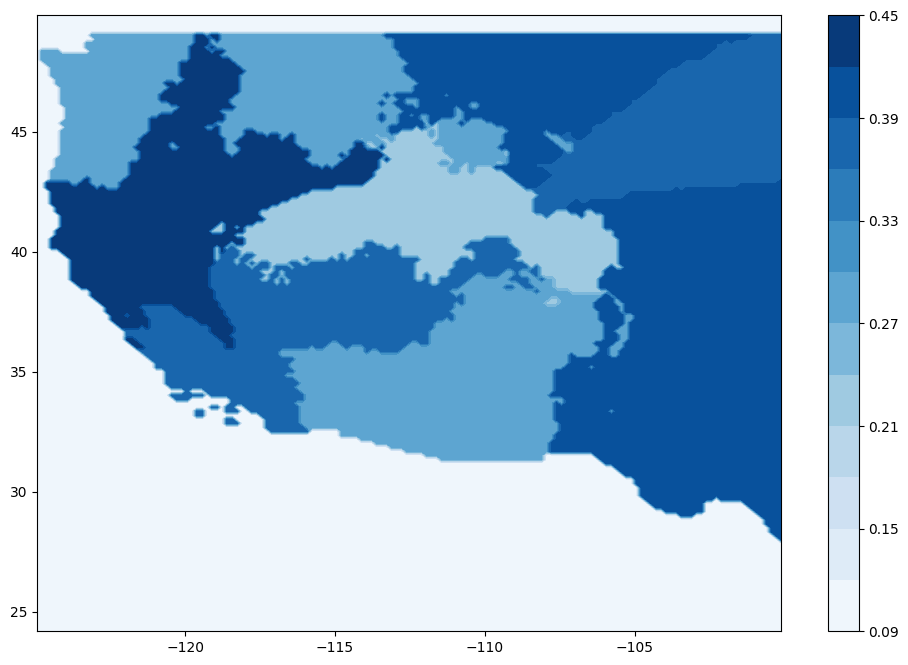

In [ ]:
# clusters is 155x150 grid of values 0-8 -> convert to grid of same size with accuracy values

cluster_map_raw = np.load("clusters.npy")
cluster_map = np.where(np.isnan(cluster_map_raw), -1, cluster_map_raw)  # replace NaNs with -1
cluster_map = cluster_map.astype(int) # convert to integer
# replace all cluster numbers with their corresponding accuracy 
cluster_map = mean_accuracies[cluster_map]
cluster_map = np.where(np.isnan(cluster_map_raw), 0.1, cluster_map)  # replace where NaNs originally were with 0
plt.figure(figsize=(12, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, cluster_map, levels=10, cmap="Blues")
plt.colorbar()
plt.show()


### Confusion Matrix


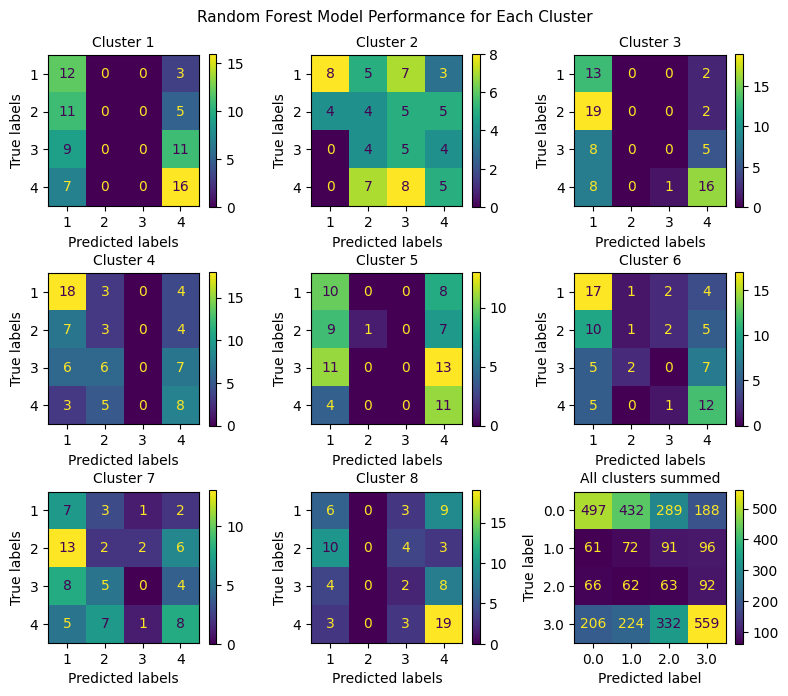

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrices(predictions, correct_labels, title=""):
    """ Plot the confusion matrices for a model for each cluster
    Args: 
        predictions (list): A list of 8 lists, where the ith list corresponds to the model predictions for cluster i+1.
        correct_labels (list): A list of 8 lists, where the ith list corresponds to the actual labels for cluster i+1
        title (str) (optioanl): A title for the figure
    """
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,7))
    spec = fig.add_gridspec(2, 4)
    flattened_axes = axes.flatten()
    for i in range(8):
        a = flattened_axes[i]
        ConfusionMatrixDisplay.from_predictions([int(x + 1) for x in correct_labels[i]], [int(x + 1) for x in predictions[i]], ax=a)
        a.set_title(label=f'Cluster {i+1}', fontdict={'fontsize':10})
        a.set_xlabel(xlabel='Predicted labels',fontdict={'fontsize':10})
        a.set_ylabel(ylabel='True labels',fontdict={'fontsize':10})
        i += 1
    ConfusionMatrixDisplay.from_predictions(np.array(predictions).flatten(),np.array(correct_labels).flatten(), ax=flattened_axes[8])
    flattened_axes[8].set_title(label="All clusters summed", fontdict={'fontsize':10})
    fig.suptitle(title, fontsize=11)
    plt.tight_layout()  
    plt.show()

plot_confusion_matrices(conf_preds, conf_labels, "Random Forest Model Performance for Each Cluster")

## Testing Hyperparameters

Use GridSearchCV library to test different values for different parameters


In [ ]:
# params = {
#     'max_depth': [1,2,3,5,10,20, 50, 100, 150, 200, 500, None],
#     'min_samples_leaf': [1, 5, 10, 20, 50, 100, 200, 500],
#     'n_estimators': [10,25,30,50,100,200]
# }

# # Assuming we have a list of clusters called 'clusters'
# # and a function 'get_cluster_data' that returns X_train and y_train for a given cluster
# best_params = {}

# for i in range(len(clusters)):
#     X_train, _, y_train, _ = get_cluster_data(i)
#     # Instantiate the grid search model
#     grid_search = GridSearchCV(estimator=rf,
#                             param_grid=params,
#                             cv = 4,
#                             n_jobs=-1, verbose=1, scoring="accuracy")

#     grid_search.fit(X_train, y_train)
        
#         # Store the best parameters for the current cluster
#     best_params[i] = grid_search.best_params_
#     best_score = grid_search.best_score_
#     best_esty = grid_search.best_estimator_
#     print(f"best accuracy cluster {i}: {best_score}")
#     print(f"best estimators cluster {i}: {best_esty}")
#     print(f"best params for cluster {i}: {best_params[i]}")


## Trying Neural Network

Creating and training a logistic regression model


#### Model


In [ ]:
# change to built in methods
class RainPrediction(nn.Module):
    def __init__(self, num_regions, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Dropout(0.05),
            nn.Linear(num_regions, 20),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(20, num_classes)
        )

    def forward(self, x):
        return self.model(x)
    

#### Training


In [ ]:
def gradient_descent(model, loss_func, train_dataset, valid_dataset, optimizer, steps=5000, batch_size=64):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    losses = []
    valid_losses = []
    for step in tqdm(range(steps)):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            loss = loss_func(model(x_batch), y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)

        model.eval()
        running_valid_loss = 0.0
        with torch.no_grad():
            for x_valid_batch, y_valid_batch in valid_loader:
                valid_loss = loss_func(model(x_valid_batch), y_valid_batch)
                running_valid_loss += valid_loss.item()
        avg_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        if (step + 1) % 10 == 0:
            print(f"Step {step+1}/{steps}, Training Loss: {avg_loss}, Validation Loss: {avg_valid_loss}")

    print(f"Final training loss: {losses[-1]}")
    print(f"Final validation loss: {valid_losses[-1]}")

    return losses, valid_losses


def calculate_accuracy(model, x, y):
    model.eval()
    with torch.no_grad():
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        return correct / total, predicted

# Iterate for all 8 clusters
nn_train_predictions_all_clusters = []
nn_test_predictions_all_clusters = []
nn_train_labels_all_clusters = []
nn_test_labels_all_clusters = []

for i in range(len(clusters)):
    print(f"\nBegin training model for cluster {i+1}")
    # Get data for this cluster
    X_train, X_test, y_train, y_test = get_cluster_data(i)

    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Initialize the model and optimizer
    model = RainPrediction(X_train.shape[1], 4)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Run the training
    losses, valid_losses = gradient_descent(
        model, nn.CrossEntropyLoss(), train_dataset, test_dataset, optimizer, steps=150
    )

    train_accuracy, nn_train_predictions = calculate_accuracy(model, X_train_tensor, y_train_tensor)
    test_accuracy, nn_test_predictions = calculate_accuracy(model, X_test_tensor, y_test_tensor)

    nn_train_predictions_all_clusters.append(nn_train_predictions.tolist())
    nn_test_predictions_all_clusters.append(nn_test_predictions.tolist())
    nn_train_labels_all_clusters.append(y_train_tensor.tolist())
    nn_test_labels_all_clusters.append(y_test_tensor.tolist())

    print(f"Training accuracy for cluster {i+1}: {train_accuracy * 100}%")
    print(f"Test accuracy for cluster {i+1}: {test_accuracy * 100}%")


Begin training model for cluster 1


 24%|██▍       | 36/150 [00:00<00:00, 123.51it/s]

Step 10/150, Training Loss: 1.333056558262218, Validation Loss: 1.3918823599815369
Step 20/150, Training Loss: 1.2884213057431309, Validation Loss: 1.3457202315330505
Step 30/150, Training Loss: 1.2625356804240833, Validation Loss: 1.3278931379318237


 43%|████▎     | 65/150 [00:00<00:00, 133.79it/s]

Step 40/150, Training Loss: 1.2484063777056607, Validation Loss: 1.3376834988594055
Step 50/150, Training Loss: 1.2044093500484119, Validation Loss: 1.408755123615265
Step 60/150, Training Loss: 1.1972674131393433, Validation Loss: 1.3960354924201965


 63%|██████▎   | 94/150 [00:00<00:00, 137.65it/s]

Step 70/150, Training Loss: 1.1859779466282239, Validation Loss: 1.46908837556839
Step 80/150, Training Loss: 1.1637358990582554, Validation Loss: 1.4868801832199097
Step 90/150, Training Loss: 1.175622203133323, Validation Loss: 1.4908958673477173


 83%|████████▎ | 124/150 [00:00<00:00, 140.53it/s]

Step 100/150, Training Loss: 1.1432244886051526, Validation Loss: 1.5569340586662292
Step 110/150, Training Loss: 1.1431257670575923, Validation Loss: 1.5403430461883545
Step 120/150, Training Loss: 1.133817027915608, Validation Loss: 1.5672540664672852


100%|██████████| 150/150 [00:01<00:00, 133.70it/s]


Step 130/150, Training Loss: 1.0781289772553877, Validation Loss: 1.5888821482658386
Step 140/150, Training Loss: 1.0480170791799372, Validation Loss: 1.6036152839660645
Step 150/150, Training Loss: 1.0413301261988552, Validation Loss: 1.617308795452118
Final training loss: 1.0413301261988552
Final validation loss: 1.617308795452118
Training accuracy for cluster 1: 54.40729483282675%
Test accuracy for cluster 1: 31.08108108108108%

Begin training model for cluster 2


 17%|█▋        | 26/150 [00:00<00:00, 125.21it/s]

Step 10/150, Training Loss: 1.4209586381912231, Validation Loss: 1.4855695962905884
Step 20/150, Training Loss: 1.3546688773415305, Validation Loss: 1.4599681496620178
Step 30/150, Training Loss: 1.3427695469422773, Validation Loss: 1.5636494159698486


 35%|███▍      | 52/150 [00:00<00:00, 125.12it/s]

Step 40/150, Training Loss: 1.3342216665094548, Validation Loss: 1.50155371427536
Step 50/150, Training Loss: 1.311190507628701, Validation Loss: 1.506912887096405
Step 60/150, Training Loss: 1.3163029497320002, Validation Loss: 1.4765946865081787


 63%|██████▎   | 94/150 [00:00<00:00, 130.23it/s]

Step 70/150, Training Loss: 1.2729569240049883, Validation Loss: 1.5632262229919434
Step 80/150, Training Loss: 1.255261475389654, Validation Loss: 1.6208168268203735
Step 90/150, Training Loss: 1.2166590148752385, Validation Loss: 1.6962000131607056


 81%|████████▏ | 122/150 [00:00<00:00, 134.20it/s]

Step 100/150, Training Loss: 1.1954901001670144, Validation Loss: 1.7145596146583557
Step 110/150, Training Loss: 1.2090605388988147, Validation Loss: 1.7226407527923584
Step 120/150, Training Loss: 1.1852199922908435, Validation Loss: 1.7365322709083557


100%|██████████| 150/150 [00:01<00:00, 131.60it/s]


Step 130/150, Training Loss: 1.1465607664801858, Validation Loss: 1.745488464832306
Step 140/150, Training Loss: 1.112871457229961, Validation Loss: 1.8277972340583801
Step 150/150, Training Loss: 1.1337432644583962, Validation Loss: 1.8058503866195679
Final training loss: 1.1337432644583962
Final validation loss: 1.8058503866195679
Training accuracy for cluster 2: 49.39209726443769%
Test accuracy for cluster 2: 21.62162162162162%

Begin training model for cluster 3


 19%|█▊        | 28/150 [00:00<00:00, 135.18it/s]

Step 10/150, Training Loss: 1.3943995887582952, Validation Loss: 1.3319646120071411
Step 20/150, Training Loss: 1.240889234976335, Validation Loss: 1.3013434410095215
Step 30/150, Training Loss: 1.1891134001991965, Validation Loss: 1.36245596408844


 38%|███▊      | 57/150 [00:00<00:00, 138.30it/s]

Step 40/150, Training Loss: 1.1165304996750571, Validation Loss: 1.4155147075653076
Step 50/150, Training Loss: 1.138939001343467, Validation Loss: 1.3867027759552002
Step 60/150, Training Loss: 1.0735596310008655, Validation Loss: 1.4791139364242554


 58%|█████▊    | 87/150 [00:00<00:00, 140.12it/s]

Step 70/150, Training Loss: 1.0351440093734048, Validation Loss: 1.3767049908638
Step 80/150, Training Loss: 1.0619534687562422, Validation Loss: 1.4819204211235046
Step 90/150, Training Loss: 1.0183114246888594, Validation Loss: 1.5133298635482788


 78%|███████▊  | 117/150 [00:00<00:00, 140.99it/s]

Step 100/150, Training Loss: 1.0132021091201089, Validation Loss: 1.5971150994300842
Step 110/150, Training Loss: 0.9588495059446855, Validation Loss: 1.5794299840927124
Step 120/150, Training Loss: 0.9764018058776855, Validation Loss: 1.4841756224632263


100%|██████████| 150/150 [00:01<00:00, 139.47it/s]


Step 130/150, Training Loss: 0.9572647593238137, Validation Loss: 1.5396062731742859
Step 140/150, Training Loss: 0.9239046736197039, Validation Loss: 1.5894171595573425
Step 150/150, Training Loss: 0.9310944513841108, Validation Loss: 1.739872694015503
Final training loss: 0.9310944513841108
Final validation loss: 1.739872694015503
Training accuracy for cluster 3: 63.981762917933125%
Test accuracy for cluster 3: 31.08108108108108%

Begin training model for cluster 4


 19%|█▊        | 28/150 [00:00<00:00, 138.19it/s]

Step 10/150, Training Loss: 1.3119485161521218, Validation Loss: 1.387391448020935
Step 20/150, Training Loss: 1.3257757425308228, Validation Loss: 1.3947877883911133
Step 30/150, Training Loss: 1.2560152574019, Validation Loss: 1.4041887521743774


 38%|███▊      | 57/150 [00:00<00:00, 140.08it/s]

Step 40/150, Training Loss: 1.2479705810546875, Validation Loss: 1.4205577373504639
Step 50/150, Training Loss: 1.2048839764161543, Validation Loss: 1.4635022282600403
Step 60/150, Training Loss: 1.2049168890172786, Validation Loss: 1.429112434387207


 57%|█████▋    | 86/150 [00:00<00:00, 134.52it/s]

Step 70/150, Training Loss: 1.1825850226662376, Validation Loss: 1.4135053157806396
Step 80/150, Training Loss: 1.1596764109351418, Validation Loss: 1.485295593738556
Step 90/150, Training Loss: 1.1310524615374478, Validation Loss: 1.4906785488128662


 77%|███████▋  | 115/150 [00:00<00:00, 137.98it/s]

Step 100/150, Training Loss: 1.0925056446682324, Validation Loss: 1.5434078574180603
Step 110/150, Training Loss: 1.0810182636434382, Validation Loss: 1.6011284589767456
Step 120/150, Training Loss: 1.088830834085291, Validation Loss: 1.6299827694892883


100%|██████████| 150/150 [00:01<00:00, 137.92it/s]


Step 130/150, Training Loss: 1.013547507199374, Validation Loss: 1.6000376343727112
Step 140/150, Training Loss: 1.0303512323986401, Validation Loss: 1.7735409140586853
Step 150/150, Training Loss: 1.001539490439675, Validation Loss: 1.686581552028656
Final training loss: 1.001539490439675
Final validation loss: 1.686581552028656
Training accuracy for cluster 4: 61.702127659574465%
Test accuracy for cluster 4: 44.5945945945946%

Begin training model for cluster 5


 19%|█▊        | 28/150 [00:00<00:00, 137.07it/s]

Step 10/150, Training Loss: 1.3263696757229892, Validation Loss: 1.4595999121665955
Step 20/150, Training Loss: 1.232320319522511, Validation Loss: 1.5814592242240906
Step 30/150, Training Loss: 1.1991507465189153, Validation Loss: 1.4994437098503113


 37%|███▋      | 56/150 [00:00<00:00, 135.84it/s]

Step 40/150, Training Loss: 1.1767771569165317, Validation Loss: 1.5413765907287598
Step 50/150, Training Loss: 1.1317295269532637, Validation Loss: 1.6769130229949951
Step 60/150, Training Loss: 1.1085250594399192, Validation Loss: 1.7761635780334473


 56%|█████▌    | 84/150 [00:00<00:00, 133.40it/s]

Step 70/150, Training Loss: 1.1167555072090842, Validation Loss: 1.6800720691680908
Step 80/150, Training Loss: 1.119923304427754, Validation Loss: 1.824803650379181
Step 90/150, Training Loss: 1.0507222305644641, Validation Loss: 1.8366806507110596


 84%|████████▍ | 126/150 [00:00<00:00, 130.85it/s]

Step 100/150, Training Loss: 1.0190315246582031, Validation Loss: 1.8844028115272522
Step 110/150, Training Loss: 1.0141302022066983, Validation Loss: 1.9591397047042847
Step 120/150, Training Loss: 1.0037181919271296, Validation Loss: 1.9153122305870056


100%|██████████| 150/150 [00:01<00:00, 132.40it/s]


Step 130/150, Training Loss: 0.984796177257191, Validation Loss: 2.1818593740463257
Step 140/150, Training Loss: 0.9473594589666887, Validation Loss: 2.1610307693481445
Step 150/150, Training Loss: 0.9019058563492515, Validation Loss: 2.284744381904602
Final training loss: 0.9019058563492515
Final validation loss: 2.284744381904602
Training accuracy for cluster 5: 61.702127659574465%
Test accuracy for cluster 5: 28.37837837837838%

Begin training model for cluster 6


 19%|█▊        | 28/150 [00:00<00:00, 136.26it/s]

Step 10/150, Training Loss: 1.3052663044496016, Validation Loss: 1.3199560046195984
Step 20/150, Training Loss: 1.2579062201760032, Validation Loss: 1.3002053499221802
Step 30/150, Training Loss: 1.220764940435236, Validation Loss: 1.2916565537452698


 38%|███▊      | 57/150 [00:00<00:00, 139.36it/s]

Step 40/150, Training Loss: 1.2355676672675393, Validation Loss: 1.3527371287345886
Step 50/150, Training Loss: 1.1993331150575117, Validation Loss: 1.3516296744346619
Step 60/150, Training Loss: 1.1665238683873957, Validation Loss: 1.4050901532173157


 58%|█████▊    | 87/150 [00:00<00:00, 139.94it/s]

Step 70/150, Training Loss: 1.1353124488483777, Validation Loss: 1.3918761610984802
Step 80/150, Training Loss: 1.1329875642603093, Validation Loss: 1.4425421357154846
Step 90/150, Training Loss: 1.1117259589108555, Validation Loss: 1.470073640346527


 77%|███████▋  | 116/150 [00:00<00:00, 140.91it/s]

Step 100/150, Training Loss: 1.122496854175221, Validation Loss: 1.512439250946045
Step 110/150, Training Loss: 1.0728549523787065, Validation Loss: 1.5100789666175842
Step 120/150, Training Loss: 1.0928235270760276, Validation Loss: 1.5847986340522766


100%|██████████| 150/150 [00:01<00:00, 139.31it/s]


Step 130/150, Training Loss: 1.0325073870745571, Validation Loss: 1.5778878927230835
Step 140/150, Training Loss: 1.029827058315277, Validation Loss: 1.6013476848602295
Step 150/150, Training Loss: 1.0206389047882773, Validation Loss: 1.6784781217575073
Final training loss: 1.0206389047882773
Final validation loss: 1.6784781217575073
Training accuracy for cluster 6: 55.01519756838906%
Test accuracy for cluster 6: 37.83783783783784%

Begin training model for cluster 7


 19%|█▉        | 29/150 [00:00<00:00, 141.28it/s]

Step 10/150, Training Loss: 1.4127063100988215, Validation Loss: 1.385737657546997
Step 20/150, Training Loss: 1.3567075295881792, Validation Loss: 1.4413162469863892
Step 30/150, Training Loss: 1.3382875810969959, Validation Loss: 1.606092929840088


 39%|███▉      | 59/150 [00:00<00:00, 139.60it/s]

Step 40/150, Training Loss: 1.3124821402809836, Validation Loss: 1.4812224507331848
Step 50/150, Training Loss: 1.2966857931830666, Validation Loss: 1.5634504556655884
Step 60/150, Training Loss: 1.271091016856107, Validation Loss: 1.6545076966285706


 58%|█████▊    | 87/150 [00:00<00:00, 139.39it/s]

Step 70/150, Training Loss: 1.2438135688955134, Validation Loss: 1.750646948814392
Step 80/150, Training Loss: 1.206890268759294, Validation Loss: 1.7551910877227783
Step 90/150, Training Loss: 1.2357360341332175, Validation Loss: 1.7869820594787598


 77%|███████▋  | 115/150 [00:00<00:00, 137.00it/s]

Step 100/150, Training Loss: 1.1734536344354802, Validation Loss: 1.8771815299987793
Step 110/150, Training Loss: 1.1343690373680808, Validation Loss: 1.9027422070503235
Step 120/150, Training Loss: 1.1343269781632856, Validation Loss: 2.0035513043403625


100%|██████████| 150/150 [00:01<00:00, 138.33it/s]


Step 130/150, Training Loss: 1.1107232679020276, Validation Loss: 1.9579021334648132
Step 140/150, Training Loss: 1.1296637491746382, Validation Loss: 1.863605558872223
Step 150/150, Training Loss: 1.0691460858691821, Validation Loss: 1.9872214198112488
Final training loss: 1.0691460858691821
Final validation loss: 1.9872214198112488
Training accuracy for cluster 7: 55.62310030395137%
Test accuracy for cluster 7: 32.432432432432435%

Begin training model for cluster 8


 19%|█▊        | 28/150 [00:00<00:00, 131.30it/s]

Step 10/150, Training Loss: 1.3670273585753008, Validation Loss: 1.4036775827407837
Step 20/150, Training Loss: 1.2947029742327603, Validation Loss: 1.4368867874145508
Step 30/150, Training Loss: 1.2761259295723655, Validation Loss: 1.4721526503562927


 39%|███▊      | 58/150 [00:00<00:00, 138.09it/s]

Step 40/150, Training Loss: 1.2533238367600874, Validation Loss: 1.4239992499351501
Step 50/150, Training Loss: 1.2536122040315107, Validation Loss: 1.5344745516777039
Step 60/150, Training Loss: 1.1786907802928577, Validation Loss: 1.500669002532959


 59%|█████▊    | 88/150 [00:00<00:00, 141.12it/s]

Step 70/150, Training Loss: 1.1756244897842407, Validation Loss: 1.4475363492965698
Step 80/150, Training Loss: 1.1625086123293096, Validation Loss: 1.4822914004325867
Step 90/150, Training Loss: 1.1243989034132524, Validation Loss: 1.5998916625976562


 79%|███████▊  | 118/150 [00:00<00:00, 140.79it/s]

Step 100/150, Training Loss: 1.1145355159586126, Validation Loss: 1.609487235546112
Step 110/150, Training Loss: 1.038085092197765, Validation Loss: 1.6583397388458252
Step 120/150, Training Loss: 1.048725182359869, Validation Loss: 1.6041728258132935


100%|██████████| 150/150 [00:01<00:00, 139.00it/s]


Step 130/150, Training Loss: 1.0210791717876087, Validation Loss: 1.7701107859611511
Step 140/150, Training Loss: 1.011079652742906, Validation Loss: 1.6760598421096802
Step 150/150, Training Loss: 0.9595592021942139, Validation Loss: 1.8254930973052979
Final training loss: 0.9595592021942139
Final validation loss: 1.8254930973052979
Training accuracy for cluster 8: 62.31003039513677%
Test accuracy for cluster 8: 21.62162162162162%

Begin training model for cluster 9


 19%|█▊        | 28/150 [00:00<00:00, 138.58it/s]

Step 10/150, Training Loss: 1.3288037993691184, Validation Loss: 1.4502652883529663
Step 20/150, Training Loss: 1.2884541858326306, Validation Loss: 1.3848868608474731
Step 30/150, Training Loss: 1.2745676690881902, Validation Loss: 1.4095738530158997


 37%|███▋      | 56/150 [00:00<00:00, 136.75it/s]

Step 40/150, Training Loss: 1.203784097324718, Validation Loss: 1.400075376033783
Step 50/150, Training Loss: 1.1821709221059626, Validation Loss: 1.4063431024551392
Step 60/150, Training Loss: 1.1547153429551558, Validation Loss: 1.3833901286125183


 56%|█████▌    | 84/150 [00:00<00:00, 137.70it/s]

Step 70/150, Training Loss: 1.1255928765643726, Validation Loss: 1.409983515739441
Step 80/150, Training Loss: 1.0839617794210261, Validation Loss: 1.4707859754562378
Step 90/150, Training Loss: 1.084677056832747, Validation Loss: 1.3906965851783752


 84%|████████▍ | 126/150 [00:00<00:00, 137.25it/s]

Step 100/150, Training Loss: 1.0161932761018926, Validation Loss: 1.4988634586334229
Step 110/150, Training Loss: 1.0546193610538135, Validation Loss: 1.657843828201294
Step 120/150, Training Loss: 1.0209852890534834, Validation Loss: 1.6030571460723877


100%|██████████| 150/150 [00:01<00:00, 137.36it/s]

Step 130/150, Training Loss: 1.004559646953236, Validation Loss: 1.6060588359832764
Step 140/150, Training Loss: 0.9872363318096508, Validation Loss: 1.6162627935409546
Step 150/150, Training Loss: 0.9565661387010054, Validation Loss: 1.5893900394439697
Final training loss: 0.9565661387010054
Final validation loss: 1.5893900394439697
Training accuracy for cluster 9: 61.246200607902736%
Test accuracy for cluster 9: 31.08108108108108%


### Plot Neural Network Confusion Matrices


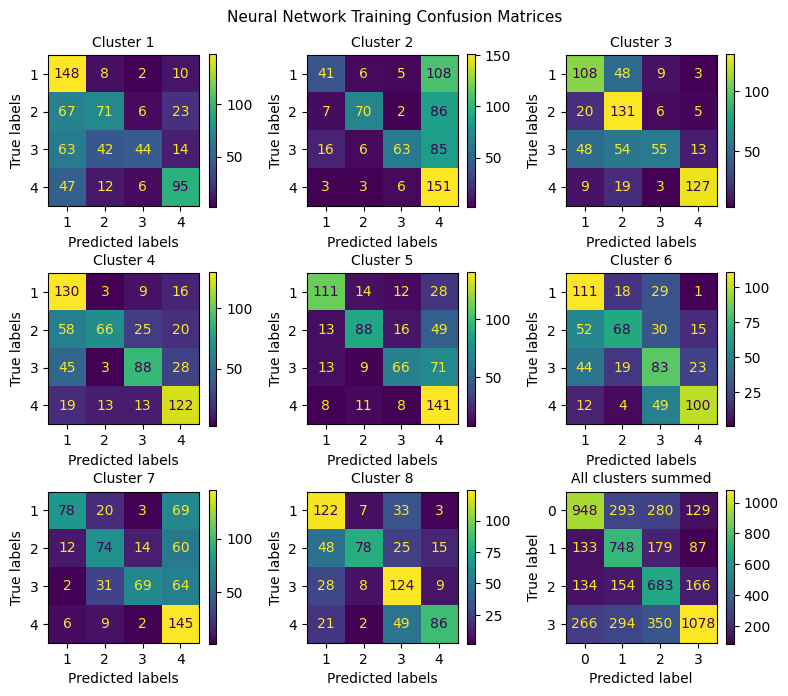

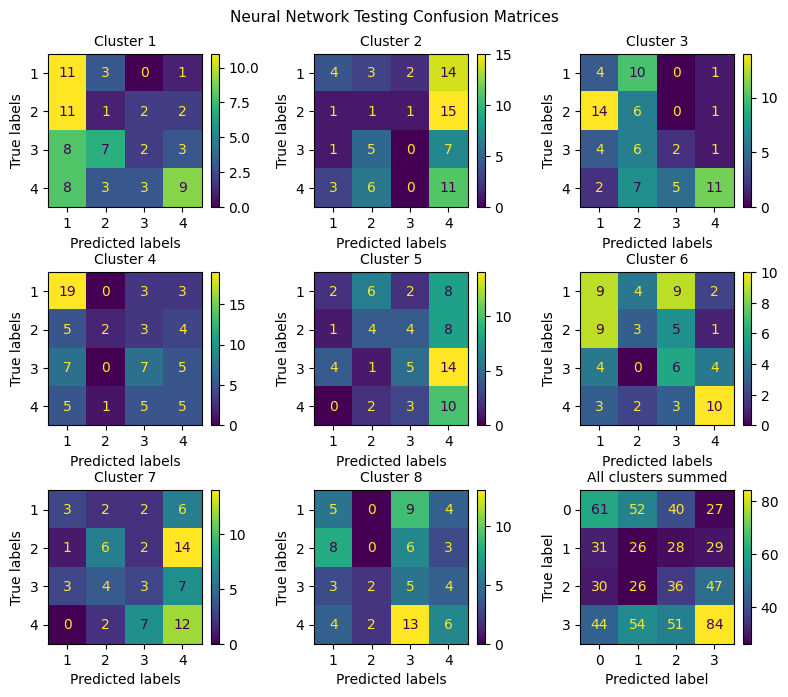

In [ ]:
plot_confusion_matrices(nn_train_predictions_all_clusters,nn_train_labels_all_clusters,title="Neural Network Training Confusion Matrices")
plot_confusion_matrices(nn_test_predictions_all_clusters,nn_test_labels_all_clusters, title="Neural Network Testing Confusion Matrices")

### Plot Training and Validation Loss


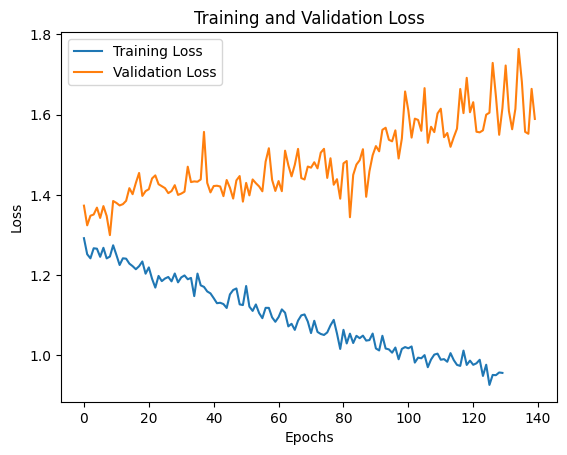

In [ ]:
# Plot and label the training and validation loss values
plt.plot(losses[20:], label='Training Loss')
plt.plot(valid_losses[10:], label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Display the plot
plt.legend(loc='best')
plt.show()

### Implement Logistic Regression


/Users/davidenders/Desktop/NN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/davidenders/Desktop/NN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

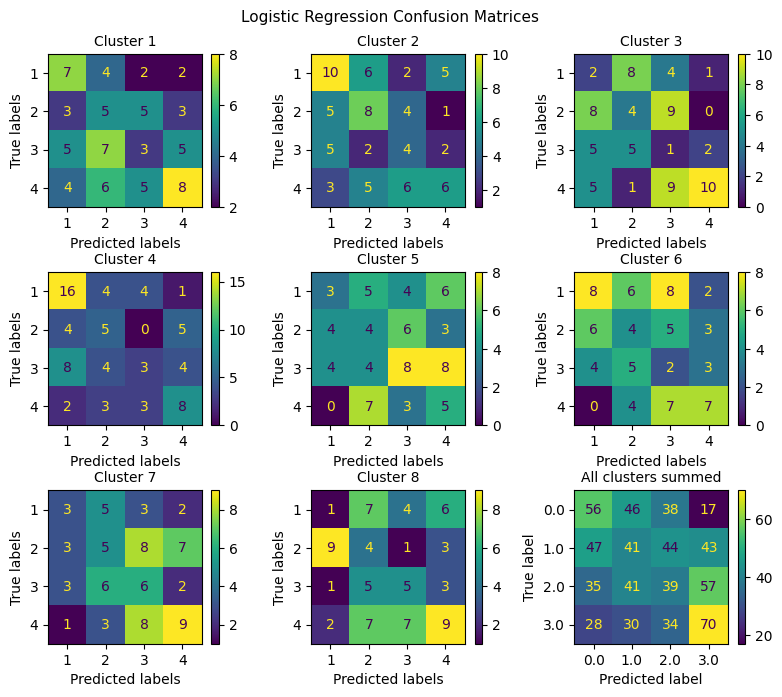

In [ ]:
model = LogisticRegression()

test_preds = []
test_labels = []

for i in range(len(clusters)):
# Get data for this cluster
    X_train, X_test, y_train, y_test = get_cluster_data(i)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    test_preds.append(preds.tolist())
    test_labels.append(y_test.tolist())

plot_confusion_matrices(test_preds, test_labels,title="Logistic Regression Confusion Matrices")